In [21]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [22]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [23]:
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3627 files belonging to 4 classes.


In [25]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy']

In [26]:
len(dataset)

29

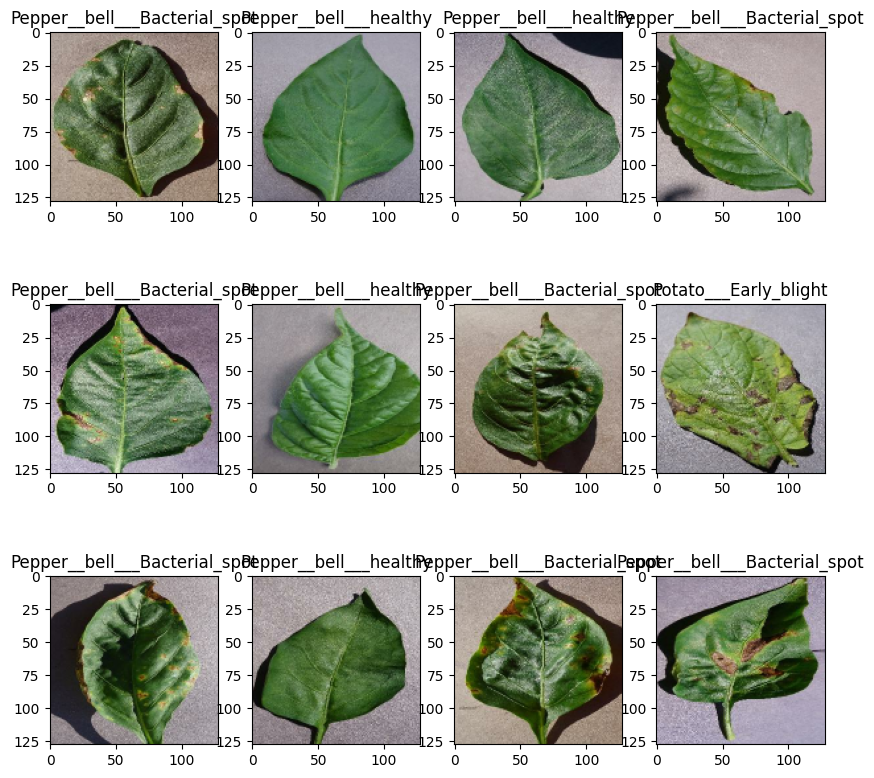

In [27]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
print(len(test_ds))
print(len(train_ds))
print(len(val_ds))

4
23
2


In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [33]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 128, 128, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 126, 126, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (128, 63, 63, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 61, 61, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 30, 30, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (128, 28, 28, 32)        

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
print(f"Training data: {len(train_ds)}")
print(f"Validation data: {len(val_ds)}")

Training data: 23
Validation data: 2


In [39]:
import tensorflow as tf
print(tf.__version__)


2.10.1


In [40]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
23/23 [==============================] - 16s 276ms/step - loss: 1.2137 - accuracy: 0.4187 - val_loss: 1.1254 - val_accuracy: 0.5781
Epoch 2/50
23/23 [==============================] - 4s 189ms/step - loss: 0.8745 - accuracy: 0.6481 - val_loss: 0.9732 - val_accuracy: 0.5586
Epoch 3/50
23/23 [==============================] - 4s 170ms/step - loss: 0.6746 - accuracy: 0.7258 - val_loss: 1.0458 - val_accuracy: 0.5078
Epoch 4/50
23/23 [==============================] - 4s 172ms/step - loss: 0.5460 - accuracy: 0.7817 - val_loss: 0.6913 - val_accuracy: 0.7031
Epoch 5/50
23/23 [==============================] - 4s 172ms/step - loss: 0.4159 - accuracy: 0.8506 - val_loss: 0.4742 - val_accuracy: 0.8203
Epoch 6/50
23/23 [==============================] - 4s 174ms/step - loss: 0.4130 - accuracy: 0.8503 - val_loss: 0.8614 - val_accuracy: 0.6250
Epoch 7/50
23/23 [==============================] - 4s 171ms/step - loss: 0.3447 - accuracy: 0.8800 - val_loss: 0.5980 - val_accuracy: 0.7695
Epoch

In [41]:
score = model.evaluate(test_ds)

4/4 [==============================] - 1s 43ms/step - loss: 0.1367 - accuracy: 0.9375


In [42]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 23}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

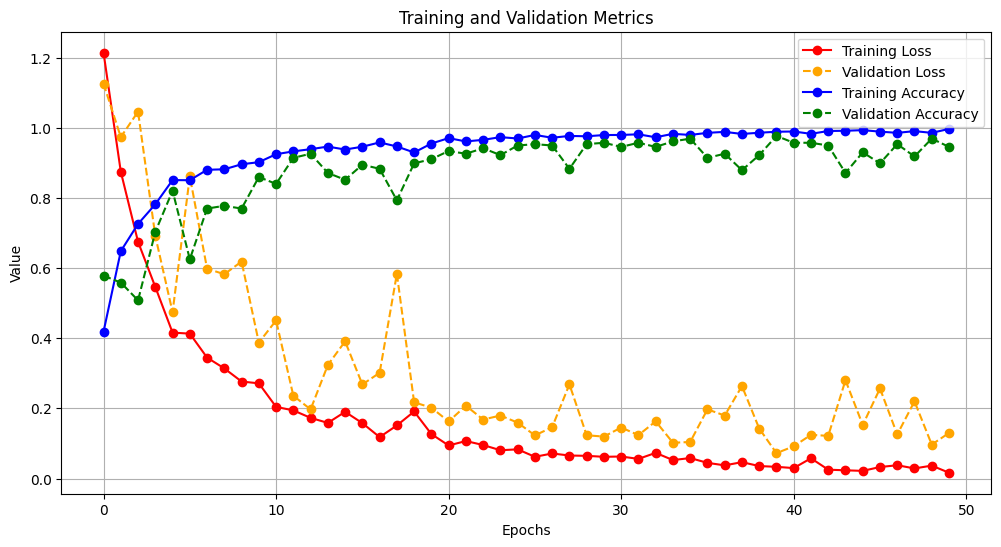

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--', color='orange')
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--', color='green')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


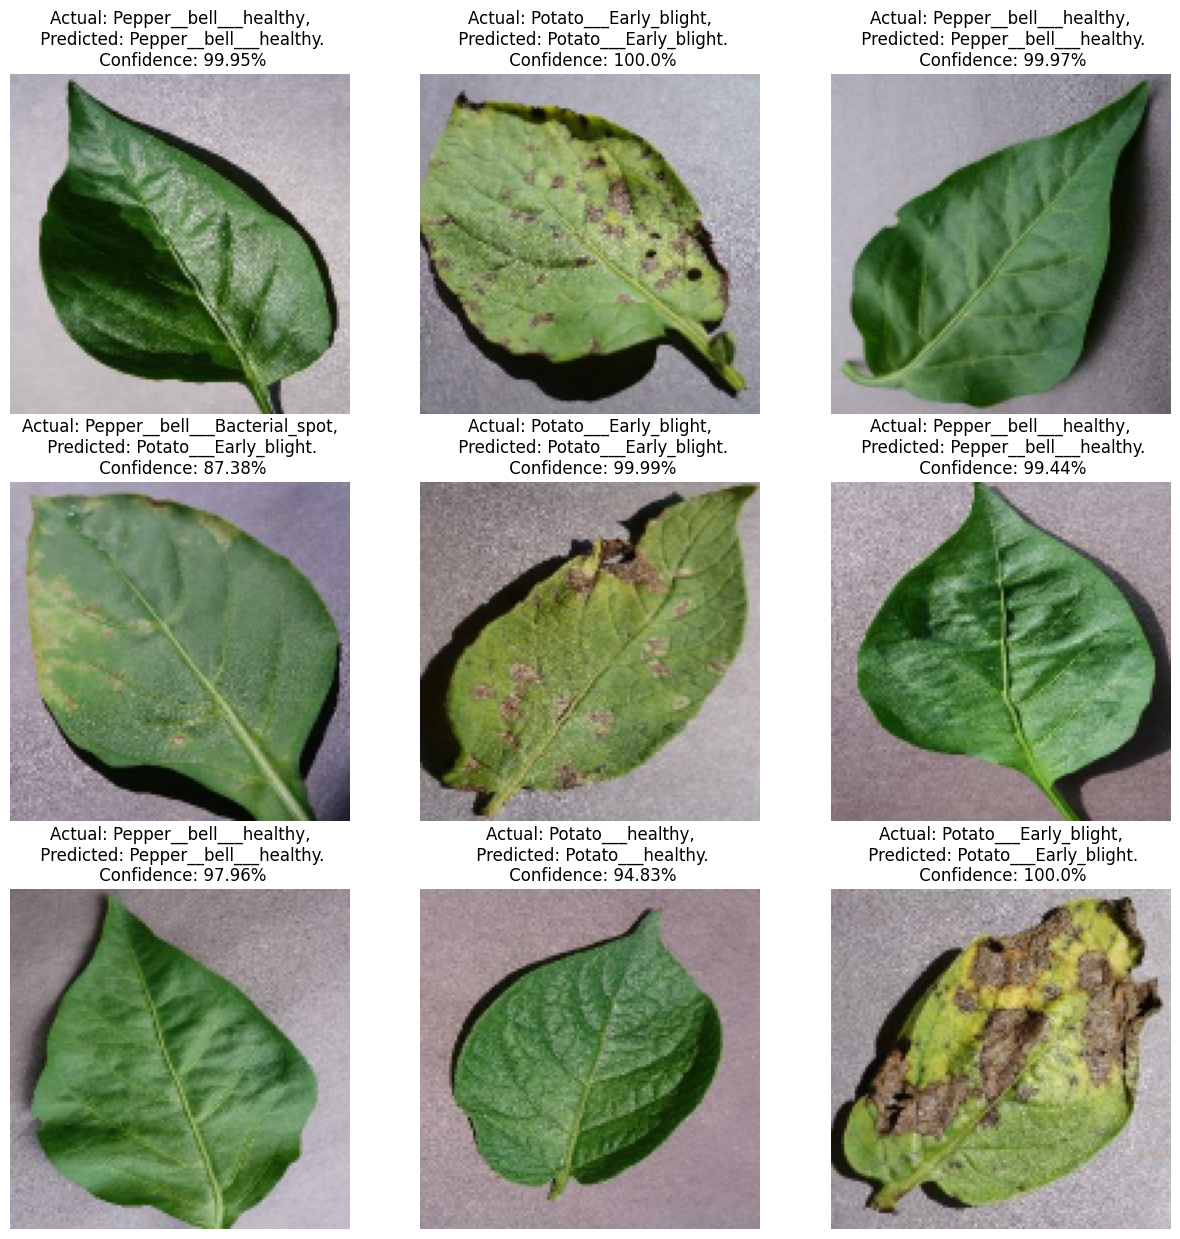

In [47]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [53]:
model.save("../potatoes.h5")

In [11]:
import yaml

config_path = r'C:\Users\gomes\OneDrive\ML Krish Naik\Potato disease classification CNN\src\config\config.yaml'

# Read the YAML file
with open(config_path, 'r') as file:
    data = yaml.safe_load(file)
print(data)

{'artifacts_root': 'artifacts'}
